In [2]:
#introducing libraries
!pip install numpy scipy pandas>1.0 matplotlib

In [3]:
#calling up libraries
from datetime import datetime
import pandas as pd
import numpy as np
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [4]:
#import CSV data
URL_AM15 = "https://raw.githubusercontent.com/alastairbuckley/PHY6000/master/AM15_G_raw.csv"
URL_EQE = "https://raw.githubusercontent.com/alastairbuckley/PHY6000/master/eqe_spectrum.csv"
URL_ALLCELL = "https://raw.githubusercontent.com/farbowitz/PHY6000/main/all_cell_efficiency.csv"
#GaAs EQE Data: Moon, Sunghyun & Kim, Kangho & Kim, Youngjo & Heo, Junseok & Jaejin, Lee. (2016). Highly efficient single-junction GaAs thin-film solar cell on flexible substrate. Scientific Reports. 6. 30107. 10.1038/srep30107. 
gaas_eqe = pd.read_csv("https://raw.githubusercontent.com/farbowitz/PHY6000/main/GaAs_data.csv", sep = ',', header=0)
#Perovskite w/Cl EQE Data: Tavakoli, Mohammad & Gu, Leilei & Gao, Yuan & Reckmeier, Claas & He, Jin & Rogach, Andrey & Yao, Yan & Fan, Zhiyong. (2015). Fabrication of efficient planar perovskite solar cells using a one-step chemical vapor deposition method. Scientific Reports. 5. 14083. 10.1038/srep14083. 
pcl_eqe = pd.read_csv("https://raw.githubusercontent.com/farbowitz/PHY6000/main/pcl_data.csv", sep = ',', header=0) 
#CdTe Cell with MZO (100C) Buffer EQE Data: Bittau, Francesco & Potamialis, Christos & Togay, Mustafa & Abbas, Ali & Isherwood, Patrick & Bowers, J. & Walls, John. (2018). Analysis and optimisation of the glass/TCO/MZO stack for thin film CdTe solar cells. Solar Energy Materials and Solar Cells. 187. 15-22. 10.1016/j.solmat.2018.07.019. 
cdte_eqe = pd.read_csv("https://raw.githubusercontent.com/farbowitz/PHY6000/main/CdTe_data.csv", sep = ',', header=0) 
#Perovskite Lead Halide EQE Data: Chang, Sheng & Cheng, Hsin-Ming & Chen, Sheng & Lin, Kuen-Feng. (2016). Optical, Excitonic, and Electronic Properties of CH3NH3PbI3 Thin Films and Their Application in Photovoltaics. 10.5772/61278.  
plh_eqe = pd.read_csv("https://raw.githubusercontent.com/farbowitz/PHY6000/main/lhp_data.csv", sep = ',', header=0)
#NREL AM0 data (2000) 
AM0_spectrum = pd.read_csv("https://raw.githubusercontent.com/farbowitz/PHY6000/main/e490_00a_amo.csv", sep = ',', header=0)
#GSpectrum
G_spectrum = pd.read_csv("https://raw.githubusercontent.com/farbowitz/PHY6000/main/G_spectrum.csv", sep = ',', header=0)
AM15_spectrum = pd.read_csv(URL_AM15, sep = ',' , header = 0)
csi_eqe = pd.read_csv(URL_EQE, sep = ',' , header = 0)    
allcell = pd.read_csv(URL_ALLCELL, sep=',', header = 0)
indx = ['c-Si', 'PCl', 'PLH', 'CdTe', 'GaAs']


In [5]:
def interpolate_wl_spectrum(input_spectrum):
  #converts into 1D array by column number
  x = np.asarray(input_spectrum[list(input_spectrum)[0]])
  y = np.asarray(input_spectrum[list(input_spectrum)[1]])
  #creates spline cubic interpolation function
  f = interp1d(x, y, 'cubic')
  #define 1nm wl array
  int_x = np.linspace(int(np.floor(np.min(x))+1), int(np.floor(np.max(x))), int(np.floor(np.max(x))-np.floor(np.min(x))))
  #get y values from interpolation 
  int_y = f(int_x)
  df = pd.DataFrame(np.stack((int_x, int_y), axis = -1), columns = ('Wavelength (nm)',1))
  return df


752.4240000000007

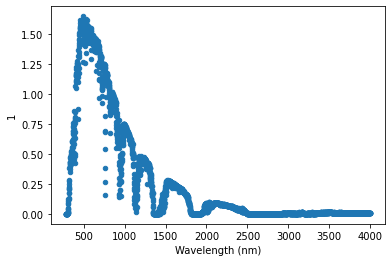

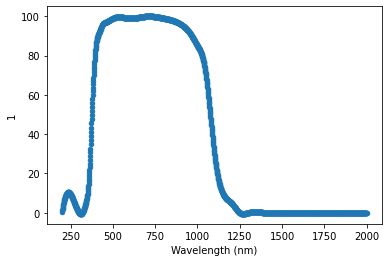

In [16]:
#interpolating all spectra to have 1nm intervals
AM15int = interpolate_wl_spectrum(AM15_spectrum)
AM0int = interpolate_wl_spectrum(AM0_spectrum)
Gint = interpolate_wl_spectrum(G_spectrum)
AM15int.plot.scatter(x='Wavelength (nm)', y=1)
csiint = interpolate_wl_spectrum(csi_eqe)
csiint.plot.scatter(x='Wavelength (nm)', y=1)
pclint = interpolate_wl_spectrum(pcl_eqe)
plhint = interpolate_wl_spectrum(plh_eqe)
CdTeint = interpolate_wl_spectrum(cdte_eqe)
GaAsint = interpolate_wl_spectrum(gaas_eqe)
rsum = 0
for i in range(60, 750):
  rsum += AM15int[1][i]
rsum

In [ ]:
def irr_to_photon_flux(input_spectrum):
  #converts into 1D array by column number
  x = np.asarray(input_spectrum[list(input_spectrum)[0]])
  y = np.asarray(input_spectrum[list(input_spectrum)[1]])
  #divides by photon energy hc/(wl) to get photon flux
  z = y*x/(1.986446e-16)
  df = pd.DataFrame(np.stack((x,z), axis=-1), columns = ('Wavelength (nm)','Number of Photons'))
  return df

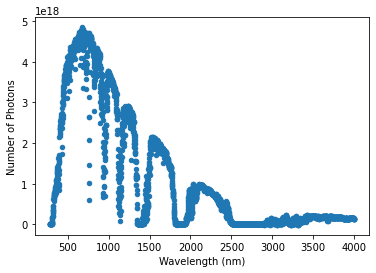

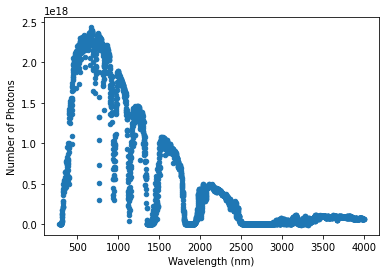

In [ ]:
AM15_photons = irr_to_photon_flux(AM15int)
AM15_photons.plot.scatter(x=0, y=1)
AM0_photons = irr_to_photon_flux(AM0int)
G_photons = irr_to_photon_flux(Gint)
G_photons.plot.scatter(x=0, y=1)

In [ ]:
def convert_to_jsc(input_flux, eqe_spectrum):
  #converts into 1D array by column number
  x = np.asarray(input_flux[list(input_flux)[0]])
  y = np.asarray(input_flux[list(input_flux)[1]])
  xe = np.asarray(eqe_spectrum[list(eqe_spectrum)[0]])
  ye = np.asarray(eqe_spectrum[list(eqe_spectrum)[1]])
#removes out of range data
  if min(xe)<min(x):
    arr = np.arange(int(min(x)-min(xe)))
    xe = np.delete(xe, arr)
    ye = np.delete(ye, arr)
  elif min(xe)>min(x):
    arr = np.arange(int(min(xe)-min(x)))
    x = np.delete(x, arr)
    y = np.delete(y, arr)
  if max(xe) > max(x):
    arr = np.arange(int(max(x)-min(x)+1), int(max(xe)+1-min(x)))
    xe = np.delete(xe, arr)
    ye = np.delete(ye, arr)
  elif max(x)>max(xe):
    arr = np.arange(int(max(xe)+1-min(x)), int(max(x)+1-min(x)))
    x = np.delete(x, arr)
    y = np.delete(y, arr)
#Uses EQE to convert photons to electrons, multiply by fundamental charge to get current per area per wl
  z = y*ye/100*1.602177e-19
#reassemble
  df = pd.DataFrame(np.stack((x,z), axis=-1), columns = ('Wavelength (nm)','Spectral Jsc (A/m^2/nm)'))
  return df

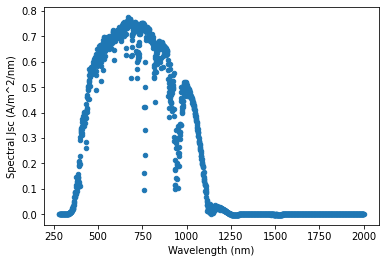

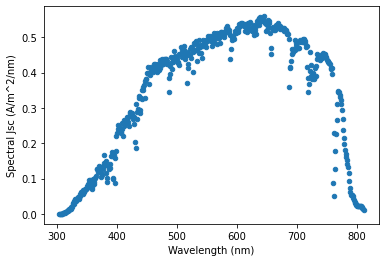

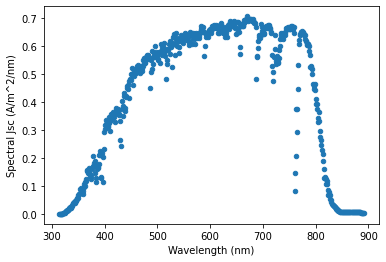

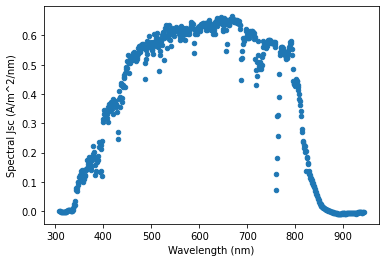

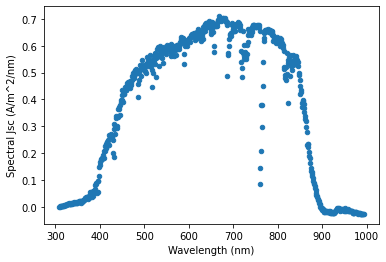

In [ ]:
#determines Jsc spectrum for each EQE
jscdata1 = convert_to_jsc(AM15_photons, csiint)
jscdata1.plot.scatter(x=0, y=1)
jscdata2 = convert_to_jsc(AM15_photons, pclint)
jscdata2.plot.scatter(x=0, y=1)
jscdata3 = convert_to_jsc(AM15_photons, plhint)
jscdata3.plot.scatter(x=0, y=1)
jscdata4 = convert_to_jsc(AM15_photons, CdTeint)
jscdata4.plot.scatter(x=0, y=1)
jscdata5 = convert_to_jsc(AM15_photons, GaAsint)
jscdata5.plot.scatter(x=0, y=1)

In [ ]:
#Creates Riemann sum of spectral Jsc
Jsc1 = np.round([np.sum(jscdata1[list(jscdata1)[1]]), np.sum(jscdata2[list(jscdata2)[1]]), np.sum(jscdata3[list(jscdata3)[1]]), np.sum(jscdata4[list(jscdata4)[1]]), np.sum(jscdata5[list(jscdata5)[1]])], 2)
pd.DataFrame(np.round(Jsc1, 2), index = indx, columns = ['Irradiance (W/m^2)'])


Irradiance (W/m^2)
c-Si              403.75
PCl               175.58
PLH               246.47
CdTe              240.85
GaAs              259.15

In [ ]:
#FF and Voc from original research where applicable. For c-Si, FF and Voc from Nelson text, PCEff from NREL chart.
FF = [.828,0.64,0.75,0.625,.8335]
Voc = [.706,0.97,1.13,0.73,.98]
Eff = [.261,.111,.193,.115,.22]
#power from FF*Voc*Jsc
P = np.asarray(FF)*np.asarray(Voc)*np.asarray(Jsc1)
#Power from summing Am15 and AM0 spectra
pam15 = np.sum(AM15int[1])

pam0 = np.sum(AM0int[1])
psumG = np.sum(Gint[1])
#comparing spectral sizes
pam0/pam15
#efficiencies from power
peffs = np.round(P/pam15,3)
#comparing to known efficiencies
percenterror = np.round(100*(np.asarray(peffs)-np.asarray(Eff))/np.asarray(Eff), 2)
coln = ['FF', 'Voc', 'Jsc (calculated; A/m^2)', 'PCE(Lit)', 'PCE(Calculated)', '%Error']
pd.DataFrame(np.stack((np.round(np.asarray(FF), 3), np.asarray(Voc), np.asarray(Jsc1), np.asarray(Eff), np.asarray(peffs), np.asarray(percenterror)), axis = -1), index=indx, columns =coln)

FF    Voc  Jsc (calculated; A/m^2)  PCE(Lit)  PCE(Calculated)  %Error
c-Si  0.828  0.706                   403.75     0.261            0.236   -9.58
PCl   0.640  0.970                   175.58     0.111            0.109   -1.80
PLH   0.750  1.130                   246.47     0.193            0.209    8.29
CdTe  0.625  0.730                   240.85     0.115            0.110   -4.35
GaAs  0.834  0.980                   259.15     0.220            0.212   -3.64

In [ ]:
#Trying to find a different way to perform user-defined functions across index
indx2 = (csiint, pclint, plhint, CdTeint, GaAsint)
Jsc2 = [0, 1, 2, 3, 4]
#Applying function across numeric indices with AM0
for i in range(5):
  Jsc2[i] = np.sum(convert_to_jsc(AM0_photons, indx2[i])['Spectral Jsc (A/m^2/nm)'])
  i += 1
#percent change in Jsc from ET spectrum to AM1.

pd.DataFrame(np.round(((np.asarray(Jsc1)-np.asarray(Jsc2))/np.asarray(Jsc2)*100), 1), index = indx, columns=['% difference'])

% difference
c-Si         -16.5
PCl          -18.5
PLH          -17.2
CdTe         -17.4
GaAs         -14.9

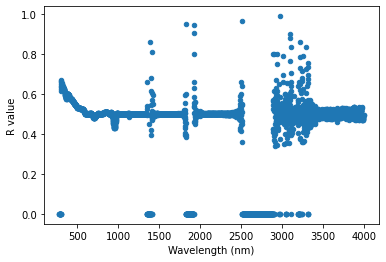

In [ ]:
#Calculating R
Rvals = np.asarray(Gint[1]/AM15int[1])
Rdata = pd.DataFrame(np.stack((np.asarray(Gint[0]), Rvals), axis=-1), columns=('Wavelength (nm)', 'R value'))
Rdata.plot.scatter(x=0, y=1)

In [ ]:
#Average Photon Energy
def avg_photon_energy_in_eV(spectrum):
  x = np.asarray(spectrum[list(spectrum)[0]])
  y = np.asarray(spectrum[list(spectrum)[1]]) 
  #total amount of energy (by wl)
  espec = y*1239.84/x
  etot = np.sum(espec)
  #add together total number of photons 
  nphotons = np.sum(y)
  val = etot/nphotons
  return val

pd.DataFrame(np.round([avg_photon_energy_in_eV(AM15_photons),avg_photon_energy_in_eV(AM0_photons),avg_photon_energy_in_eV(G_photons)], 2), index = ('Am15', 'Am0', 'G'), columns = ["Eavg (eV)"])

Eavg (eV)
Am15       1.45
Am0        1.30
G          1.47